In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict

from sklearn.model_selection import train_test_split
from tensorflow import keras

from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

# from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.callbacks import ModelCheckpoint



import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

import gc

print("Loading Libraries Done")

Loading Libraries Done


In [49]:
main_folder ="D:\\Neeru\\Python & DataScience\\Live projects\\RP_Project\\RP_dataset"

categories = os.listdir(main_folder)
# try:
#     categories.remove(".DS_Store")
# except:
#     pass
print(categories, len(categories))

['Normal', 'RP'] 2


In [ ]:

IMAGE_SIZE = (224, 224, 3)

def image_preprocessing_with_balanced_augmentation(main_folder, categories):
    img_lst = []
    labels = []

    image_counts = defaultdict(int)
    image_paths_by_class = defaultdict(list)

    # Step 1: Collect image paths
    for index, category in enumerate(categories):
        folder_path = os.path.join(main_folder, category)
        for image_name in os.listdir(folder_path):
            file_ext = image_name.split(".")[-1].lower()
            if file_ext in ["jpg", "jpeg", "png", "bmp"]:
                image_counts[index] += 1
                image_paths_by_class[index].append(os.path.join(folder_path, image_name))

    max_count = max(image_counts.values())  # 2676 in your case

    # Step 2: Load images and augment only the minority class
    for index, category in enumerate(categories):
        print(f"Processing category: {category}")

        current_images = image_paths_by_class[index]
        total_original = len(current_images)
        augment_needed = max_count - total_original
        augmented_count = 0

        for image_path in tqdm(current_images):
            try:
                img = cv2.imread(image_path)
                img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Add original image
                img_lst.append(np.array(img))
                labels.append(index)

                # Augment only the minority class
                if augment_needed > 0 and augmented_count < augment_needed:
                    for aug_img in [cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE),
                                    cv2.flip(img, 1),
                                    cv2.flip(img, 0)]:
                        if augmented_count >= augment_needed:
                            break
                        img_lst.append(np.array(aug_img))
                        labels.append(index)
                        augmented_count += 1

            except Exception as e:
                print("Error with image:", image_path, e)

        # ✅ Debug print for RP class
        if category == "RP":
            print(f"Augmented RP image count: {augmented_count}")

    # Step 3: Convert to numpy arrays
    images = np.array(img_lst, dtype=np.float32) / 255.0
    labels = np.array(labels, dtype=np.int8)
    return images, labels


In [51]:
images, labels = image_preprocessing_with_balanced_augmentation(main_folder, categories)
print("Balanced dataset shape:", images.shape, labels.shape)


Processing category: Normal


100%|██████████| 2676/2676 [01:13<00:00, 36.47it/s]


Processing category: RP


100%|██████████| 834/834 [00:22<00:00, 37.72it/s]


Augmented RP image count: 1842
Balanced dataset shape: (5352, 224, 224, 3) (5352,)


In [52]:
# x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.1, random_state = 6)
# print("x_train shape = ",x_train.shape)
# print("y_train shape = ",y_train.shape)
# print("\nx_test shape = ",x_test.shape)
# print("y_test shape = ",y_test.shape)

# First split into train+val and test
x_temp, x_test, y_temp, y_test = train_test_split(images, labels, test_size=0.1, random_state=6)

# Then split x_temp into train and val
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.1, random_state=6)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


x_train shape: (4334, 224, 224, 3)
y_train shape: (4334,)
x_val shape: (482, 224, 224, 3)
y_val shape: (482,)
x_test shape: (536, 224, 224, 3)
y_test shape: (536,)


In [53]:
del labels
del images

In [54]:
EPOCHS = 10
BATCH_SIZE = 16

### CNN MODEL

In [55]:
model = Sequential()

# Conv Block 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

# Conv Block 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

# Conv Block 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

# Flatten + Dense Layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Prevent overfitting
model.add(Dense(1, activation='sigmoid'))  # Binary classification


c:\Users\hp\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [56]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [57]:
#Early stopping to avoid overfitting of model
early_stop = EarlyStopping(
    monitor='val_accuracy', 
    patience=3, 
    restore_best_weights=True,
    verbose=1
)


### Model Training

In [63]:
# fit the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    shuffle=True
)

# history = model.fit(x_train, y_train, 
#                             validation_data=(x_test, y_test), 
#                             steps_per_epoch = 10, epochs=EPOCHS, callbacks=[early_stop], 
#                             batch_size=BATCH_SIZE, 
#                             validation_steps = y_test.shape[0]//BATCH_SIZE, shuffle=True)

Epoch 1/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 176s 641ms/step - accuracy: 0.8366 - loss: 1.7208 - val_accuracy: 0.8195 - val_loss: 0.6647
Epoch 2/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 181s 668ms/step - accuracy: 0.8738 - loss: 0.2528 - val_accuracy: 0.9004 - val_loss: 0.2813
Epoch 3/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 178s 657ms/step - accuracy: 0.8835 - loss: 0.2589 - val_accuracy: 0.9627 - val_loss: 0.1061
Epoch 4/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 188s 694ms/step - accuracy: 0.8936 - loss: 0.2236 - val_accuracy: 0.9481 - val_loss: 0.1510
Epoch 5/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 177s 653ms/step - accuracy: 0.9062 - loss: 0.2132 - val_accuracy: 0.9066 - val_loss: 0.2818
Epoch 6/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 177s 652ms/step - accuracy: 0.9067 - loss: 0.2200 - val_accuracy: 0.8278 - val_loss: 0.6564
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.


In [64]:
tf.keras.backend.clear_session()
loss, acc = model.evaluate(x_test,y_test,batch_size=32)
print("model Loss:", loss)
print("model Accuracy:", acc*100, "%")

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.9668 - loss: 0.0853
model Loss: 0.08889966458082199
model Accuracy: 96.45522236824036 %


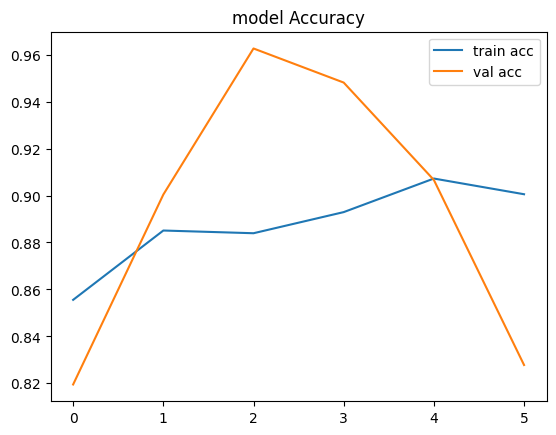

In [65]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title("model Accuracy")
plt.legend()
plt.show()

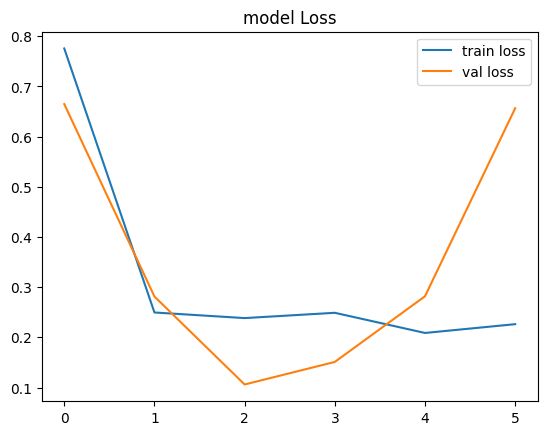

In [66]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title("model Loss")
plt.legend()
plt.show()

In [67]:
#predict
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5).astype("int32").flatten()
print(classification_report(y_pred,y_test))#get classification report

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       267
           1       0.97      0.96      0.96       269

    accuracy                           0.96       536
   macro avg       0.96      0.96      0.96       536
weighted avg       0.96      0.96      0.96       536



In [70]:
print(confusion_matrix(y_pred,y_test))#get confusion matrix

model.save("RP_detection_model.h5", save_format="h5")


[[258   9]
 [ 10 259]]
